# Loan Club Machine Learning prediction using XGBoost, Optuna and Streamlit

Being able to accurately assess the risk of a loan application can save a lender the cost of holding too many risky assets.

Without having a credit score or credit history we will try to predict how profitable a loan will be compared to our loans database, accumulated over the years. 

* The first step of our plan is to create a machine learning model to classify loans into paid/charged off so that we can start learning if you have enough data to solve this simple problem adequately. 

* The second step is to predict the grade for the loan

# Some column meanings explained

* **loan_amnt** The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.
* **term**  The number of payments on the loan. Values are in months and can be either 36 or 60.
* **int_rate**  Interest Rate on the loan
* **installment** The monthly payment owed by the borrower if the loan originates.
* **grade** LC assigned loan grade
* **sub_grade** LC assigned loan subgrade
* **emp_length**  Employment length in years. Possible values are between 0 and * 10 where 0 means less than one year and 10 means ten or more years.
* **home_ownership**  The homeownership status provided by the borrower during registration or obtained from the credit report. Our values are: RENT, OWN, MORTGAGE, OTHER
* **annual_inc**  The self-reported annual income provided by the borrower during registration.
* **verification_status** Indicates if income was verified by LC, not verified, or if the income source was verified
* **issue_d** The month in which the loan was funded
* **loan_status** Current status of the loan
* **purpose** A category provided by the borrower for the loan request.
* **title** The loan title provided by the borrower
* **zip_code**  The first 3 numbers of the zip code provided by the borrower in the loan application.
* **addr_state**  The state provided by the borrower in the loan application
* **dti** A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income.
* **earliest_cr_line**  The month the borrower's earliest reported credit line was opened
* **open_acc**  The number of open credit lines in the borrower's credit file.
* **pub_rec** Number of derogatory public records
* **revol_bal** Total credit revolving balance
* **revol_util**  Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit.
* **total_acc** The total number of credit lines currently in the borrower's credit file
* **initial_list_status** The initial listing status of the loan. Possible values are – W, F
* **application_type**  Indicates whether the loan is an individual application or a joint application with two co-borrowers
* **mort_acc**  Number of mortgage accounts.
* **pub_rec_bankruptcies**  Number of public record bankruptcies

# Imports

In [1]:
!pip install pyspark
from pyspark import SparkContext                                    
from pyspark.sql import SparkSession, Window, Row                   
from pyspark.sql import functions                                 
from pyspark.sql.functions import *                                
from pyspark.sql.types import *   
from pyspark.ml.feature import VectorAssembler   

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 KB 11.2 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.3.2-py2.py3-none-any.whl size=281824025 sha256=eea3478614af165c9d3cc92ce33763945d5dbbeb2cdd8270e371f59c27a22d74
  Stored in directory: /root/.cache/pip/wheels/6c/e3/9b/0525ce8a69478916513509d43693511463c6468db0de237c86
Successfully built pyspark


In [2]:
import numpy as np                              
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import plotly.express as px                                   
import seaborn as sns                                               
import pandas as pd                                         
from sklearn.preprocessing import LabelEncoder
import scipy.stats as stats   
from sklearn.model_selection import train_test_split  
from imblearn.combine import SMOTETomek
from sklearn.model_selection import GridSearchCV  

import warnings                                                     
warnings.filterwarnings("ignore")

In [3]:
#! pip install xgboost==1.6.2
#import xgboost
#xgboost.__version__

In [4]:
!pip install shap
import shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.4/572.4 KB 9.9 MB/s eta 0:00:00


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
def plot_bar(dataframe, column_name):
  df1 = pd.DataFrame(dataframe, columns=[column_name, 'loan_status'])

  df_2 = df1.groupby([column_name, 'loan_status']).size().reset_index()
  df_2['percentage'] = dataframe.groupby([column_name, 'loan_status']).size().groupby(level=0).apply(lambda x: 100 * x / float(x.sum())).values
  df_2.columns = [column_name, 'loan_status', 'Counts', 'Percentage']

  fig = px.bar(df_2, 
              x= column_name, 
              y=['Counts'], 
              color='loan_status', 
              color_continuous_scale=px.colors.diverging.Portland,
              text=df_2['Percentage'].apply(lambda x: '{0:1.2f}%'.format(x)))
  fig.update_coloraxes(showscale=False)

  fig.update_layout(
    autosize=False,
    width=1000,
    height=700)

  fig.show()


def plot_kde(column_name):
  str_only = df[df['loan_status'] == "Charged Off"]
  no_str_only = df[df['loan_status'] == "Fully Paid"]
  
  fig = plt.figure(figsize=(14,10))
  ax = fig.add_subplot()


  positive = pd.DataFrame(str_only[column_name])
  negative = pd.DataFrame(no_str_only[column_name])
  sns.kdeplot(positive[column_name], ax=ax,color="#0f4c81", shade=True, ec='black',label="Charged Off")
  sns.kdeplot(negative[column_name], ax=ax, color="#9bb7d4", shade=True, ec='black',label="Fully Paid")

  plt.ticklabel_format(style='plain')
  ax.yaxis.set_major_locator(mtick.MultipleLocator(2))
  ax.xaxis.set_minor_formatter(mtick.ScalarFormatter())
  ax.set_ylabel('')    
  ax.set_xlabel('')
  ax.legend()
  plt.show()


def draw_box_plot(dataframe):
  number = 0
  fig, ax = plt.subplots(1, 10, figsize=(24, 12))
  plt.subplots_adjust(wspace=1) 

  for column_name in column_names:
    sns.boxplot(data=df[column_name], ax=ax[number], palette = 'Blues')
    ax[number].set_xlabel(column_name)
    number += 1

  for subplot in ax:
    subplot.set_xticklabels([])
  plt.show()


## Imports for XGBoost

In [7]:
from xgboost import XGBClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, recall_score, mean_squared_error, r2_score, roc_auc_score, roc_curve, auc,precision_score
from sklearn.model_selection import cross_val_score
from imblearn.combine import SMOTETomek

In [8]:
!pip install optuna
import optuna 
from optuna import Trial, visualization
from optuna.samplers import TPESampler

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.3/365.3 KB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 8.4 MB/s eta 0:00:00


In [9]:
def evaluation(prediction):
  print("\n R-Squared : ", r2_score(y_validation_set, prediction) * 100)
  print('\n ROC AUC Score : ', roc_auc_score(y_validation_set, prediction))
  print("\n Model Accuracy : ",metrics.accuracy_score(y_validation_set, prediction))
  print(classification_report(y_validation_set, prediction))

In [10]:
def evaluation_multi(prediction):
  print("\n R-Squared : ", r2_score(y_validation_set, prediction) * 100)
  print('\n ROC AUC Score : ', roc_auc_score(y_validation_set, fitted_model.predict_proba(X_validation_set), multi_class="ovr"))
  print("\n Model Accuracy : ",metrics.accuracy_score(y_validation_set, prediction))
  print(classification_report(y_validation_set, prediction))

In [11]:
def classification_multi(trial):

  param = {
      "verbosity": 0,  # 0 (silent) - 3 (debug)
      "objective": "binary:logistic",
      "tree_method": "exact",
      "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
      "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
      "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
      "subsample": trial.suggest_float("subsample", 0.2, 1.0),
      "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
  }

  if param["booster"] in ["gbtree", "dart"]:
    param["max_depth"] = trial.suggest_int("max_depth", 3, 9, step=2)
    param["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 10)
    param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
    param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
    param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

  if param["booster"] == "dart":
    param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
    param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
    param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
    param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)

  

  model = XGBClassifier(random_state=42, **param)
  model.fit(X_training_set, y_training_set, eval_set=[(X_validation_set, y_validation_set)],verbose=False)

  predicted_values = model.predict(X_validation_set)
  roc_auc_score1= roc_auc_score(y_validation_set, model.predict_proba(X_validation_set), multi_class="ovr")
  return roc_auc_score1

In [542]:
def classification(trial):

  param = {
      "verbosity": 0,  # 0 (silent) - 3 (debug)
      "objective": "binary:logistic",
      "tree_method": "exact",
      "booster": trial.suggest_categorical("booster", ["gbtree"]),
      "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
      "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
      "subsample": trial.suggest_float("subsample", 0.2, 1.0),
      "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
  }

  if param["booster"] in ["gbtree"]:
    param["max_depth"] = trial.suggest_int("max_depth", 3, 9, step=2)
    param["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 10)
    param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
    param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
    param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])


  model = XGBClassifier(random_state=42, **param)
  model.fit(X_training_set,y_training_set, eval_set=[(X_validation_set,y_validation_set)],verbose=False)

  predicted_values = model.predict(X_validation_set)
  roc_auc_score1 = roc_auc_score(y_validation_set, predicted_values)
  return roc_auc_score1

# Managing data with PySpark

In [13]:
!unzip "/content/drive/My Drive/lending-club.zip"

Archive:  /content/drive/My Drive/lending-club.zip
  inflating: accepted_2007_to_2018Q4.csv.gz  
  inflating: accepted_2007_to_2018q4.csv/accepted_2007_to_2018Q4.csv  
  inflating: rejected_2007_to_2018Q4.csv.gz  
  inflating: rejected_2007_to_2018q4.csv/rejected_2007_to_2018Q4.csv  


In [14]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [15]:
!wget -q https://dlcdn.apache.org/spark/spark-3.3.2/spark-3.3.2-bin-hadoop3.tgz

In [16]:
!tar xf spark-3.3.2-bin-hadoop3.tgz

In [17]:
import os
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = '/content/spark-3.3.2-bin-hadoop3'

In [18]:
!pip install -q findspark
import findspark
findspark.init()
findspark.find()

'/content/spark-3.3.2-bin-hadoop3'

In [19]:
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder \
    .master('local[*]') \
    .config("spark.driver.memory", "15g") \
    .appName('loan_club') \
    .getOrCreate()

In [20]:
accepted = spark.read.csv("accepted_2007_to_2018q4.csv/accepted_2007_to_2018Q4.csv", header=True, inferSchema=True)

In [21]:
accepted.show(10)

+--------+---------+---------+-----------+---------------+----------+--------+-----------+-----+---------+--------------------+----------+--------------+----------+-------------------+--------+-----------+----------+--------------------+----+------------------+--------------------+--------+----------+-----+-----------+----------------+--------------+---------------+--------------+----------------------+----------------------+--------+-------+---------+----------+---------+-------------------+---------+-------------+------------------+---------------+---------------+-------------+------------------+----------+-----------------------+------------+---------------+------------+------------------+--------------------+-------------------+--------------------------+---------------------------+-----------+----------------+----------------+---------+-------------------------+--------------+------------+-----------+-----------+-----------+-----------+-----------+------------------+------------+-

**Dropping dublicates**

In [22]:
accepted =  accepted.dropDuplicates()

**Dropping not so usefull columns**

* Payment plan has all the values "n" and only 3 values "y" so it is not important

* Since we have both address state and zip code let's drop zip code and use address state only

* Title is not important instead we will use "purpose" variable
* Employement type is not quite uniformed, so we will skip it for now

In [23]:
cols = ("url","desc", "pymnt_plan", "member_id", "zip_code", "title", "emp_title") 
accepted = accepted.drop(*cols)

# Cleaning dataframe
**Droping columns that are empty**

In [24]:
import pyspark.sql.functions as F

null_counts = accepted.select([F.count(F.when(F.col(c).isNull(), c)).alias(
    c) for c in accepted.columns]).collect()[0].asDict()
print(null_counts)
  
df_size = accepted.count()

to_drop = [k for k, v in null_counts.items() if v == df_size]
print(to_drop)
  
accepted = accepted.drop(*to_drop) 
accepted.show(truncate=False)

{'id': 0, 'loan_amnt': 33, 'funded_amnt': 33, 'funded_amnt_inv': 33, 'term': 33, 'int_rate': 33, 'installment': 33, 'grade': 33, 'sub_grade': 33, 'emp_length': 146940, 'home_ownership': 33, 'annual_inc': 37, 'verification_status': 33, 'issue_d': 33, 'loan_status': 33, 'purpose': 34, 'addr_state': 34, 'dti': 1745, 'delinq_2yrs': 63, 'earliest_cr_line': 63, 'fico_range_low': 34, 'fico_range_high': 34, 'inq_last_6mths': 64, 'mths_since_last_delinq': 1158374, 'mths_since_last_record': 1901354, 'open_acc': 143, 'pub_rec': 125, 'revol_bal': 87, 'revol_util': 1867, 'total_acc': 83, 'initial_list_status': 50, 'out_prncp': 50, 'out_prncp_inv': 54, 'total_pymnt': 46, 'total_pymnt_inv': 44, 'total_rec_prncp': 42, 'total_rec_int': 36, 'total_rec_late_fee': 36, 'recoveries': 35, 'collection_recovery_fee': 39, 'last_pymnt_d': 2467, 'last_pymnt_amnt': 36, 'next_pymnt_d': 1345119, 'last_credit_pull_d': 158, 'last_fico_range_high': 76, 'last_fico_range_low': 68, 'collections_12_mths_ex_med': 201, 'mths

**Droping columns that have value NULL in grade and subrade**

In [25]:
accepted = accepted.na.drop(subset=["grade","sub_grade"])

We will drop all current loans - not paid yet and not charged off. They would not benefit us yet, as we are interested only in loans that already have an outcome. 

In [26]:
accepted.withColumn("loan_status",accepted.loan_status.cast('string'))

DataFrame[id: string, loan_amnt: double, funded_amnt: double, funded_amnt_inv: double, term: string, int_rate: double, installment: double, grade: string, sub_grade: string, emp_length: string, home_ownership: string, annual_inc: string, verification_status: string, issue_d: string, loan_status: string, purpose: string, addr_state: string, dti: string, delinq_2yrs: string, earliest_cr_line: string, fico_range_low: string, fico_range_high: string, inq_last_6mths: string, mths_since_last_delinq: string, mths_since_last_record: string, open_acc: string, pub_rec: string, revol_bal: string, revol_util: string, total_acc: string, initial_list_status: string, out_prncp: string, out_prncp_inv: string, total_pymnt: string, total_pymnt_inv: string, total_rec_prncp: string, total_rec_int: string, total_rec_late_fee: string, recoveries: string, collection_recovery_fee: string, last_pymnt_d: string, last_pymnt_amnt: string, next_pymnt_d: string, last_credit_pull_d: string, last_fico_range_high: str

In [27]:
accepted = accepted.where((accepted.loan_status == 'Fully Paid') | (accepted.loan_status == 'Charged Off'))
accepted = accepted.dropDuplicates()

In [28]:
accepted.groupBy('loan_status').count().orderBy('count').show()

+-----------+-------+
|loan_status|  count|
+-----------+-------+
|Charged Off| 268558|
| Fully Paid|1076751|
+-----------+-------+



## Home_ownership cleanup

There are some values in the home_ownership column that are not quite clear. For example, OTHER, or ANY. 

Let's drop those rows out and build our model based on clear information, meaning knowing that our customer is either owning or renting their house, or already has a mortgage for it. 

In [29]:
accepted.groupBy('home_ownership').count().orderBy('count').show()

+--------------+------+
|home_ownership| count|
+--------------+------+
|          NONE|    48|
|         OTHER|   144|
|           ANY|   286|
|           OWN|144832|
|          RENT|534421|
|      MORTGAGE|665578|
+--------------+------+



In [30]:
accepted = accepted.where((accepted.home_ownership == 'NONE') | (accepted.home_ownership == 'MORTGAGE') | (accepted.home_ownership == 'RENT') | (accepted.home_ownership == 'OWN'))

Saving the last 100 000 records to the pandas data frame. 
We only need the newest data for such predictions, as the financial sector is changing very fast.

In [31]:
sample = accepted.sort('id').limit(10000)

## Saving to pandas 

In [32]:
pandas_df = sample.toPandas()

In [33]:
pandas_df.to_csv('df.csv')
!cp df.csv "drive/My Drive/"

In [34]:
import gc
gc.collect()

575

In [35]:
spark.stop()

# EDA

In [543]:
df = pd.read_csv('/content/drive/My Drive/df.csv', index_col=[0])

In [544]:
df.head()

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,1000007,5150.0,5150.0,5150.0,60 months,18.64,132.58,E,E1,1 year,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,100001133,30000.0,30000.0,30000.0,36 months,8.24,943.42,B,B1,10+ years,...,NaN,NaN,Cash,Y,Jan-2019,ACTIVE,Jan-2019,7723.0,50.0,12.0
2,100001137,7200.0,7200.0,7200.0,36 months,28.69,300.51,F,F1,10+ years,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,100001158,7000.0,7000.0,7000.0,36 months,11.49,230.80,B,B5,9 years,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,100001163,11200.0,11200.0,11200.0,36 months,13.99,382.74,C,C3,3 years,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


In [545]:
df = df.drop(columns=['id'])
df.shape

(10000, 143)

In [546]:
gc.collect()

6504

## Outliers

In [547]:
column_names = [
 'loan_amnt',
 'installment',
 'annual_inc',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'mort_acc',
 'pub_rec_bankruptcies']

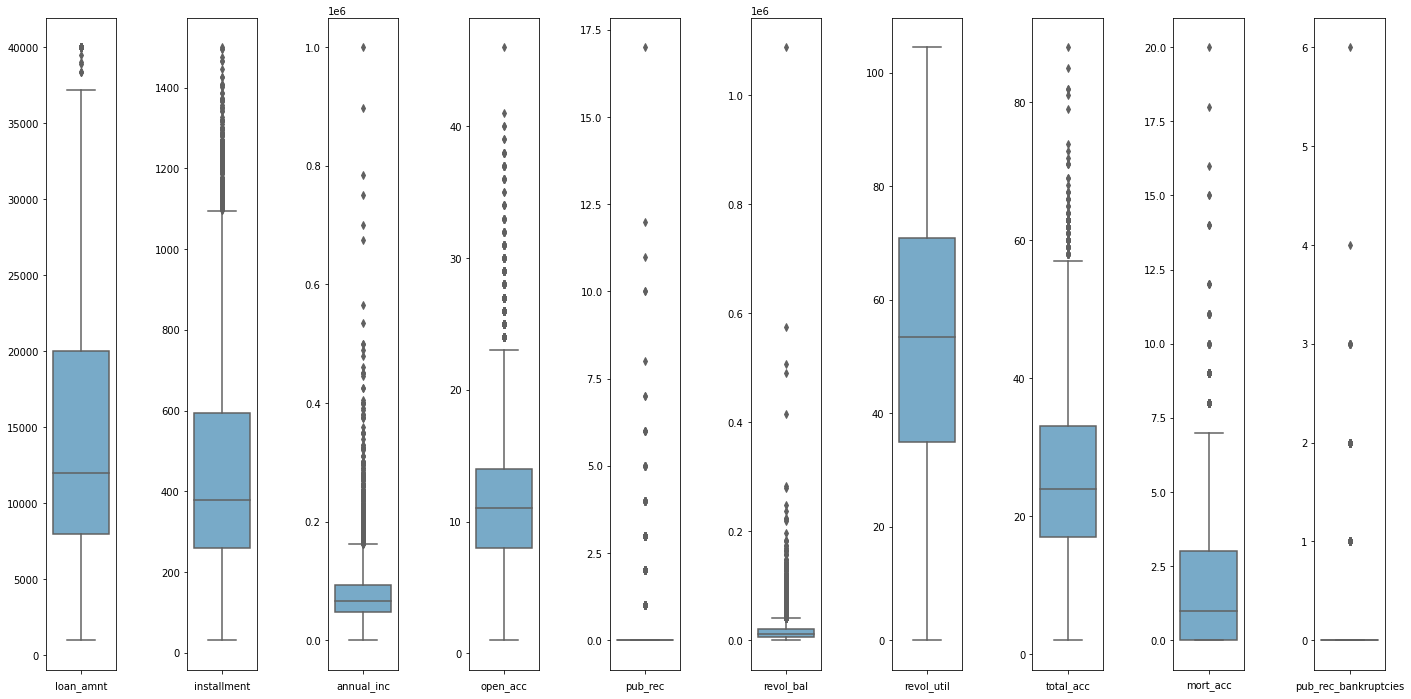

In [548]:
draw_box_plot(df)

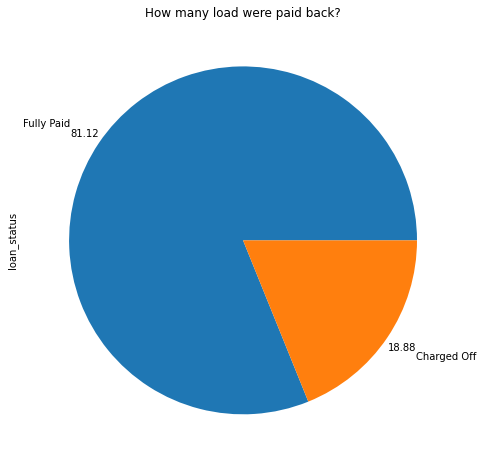

In [549]:
fig = plt.figure(figsize =(8, 8))
df.loan_status.value_counts(normalize=True).plot.pie(autopct='%.2f', 
                                                 pctdistance=1.1, 
                                                 labeldistance=1.2)
plt.title('How many load were paid back?')
plt.show()

## Loan amount 

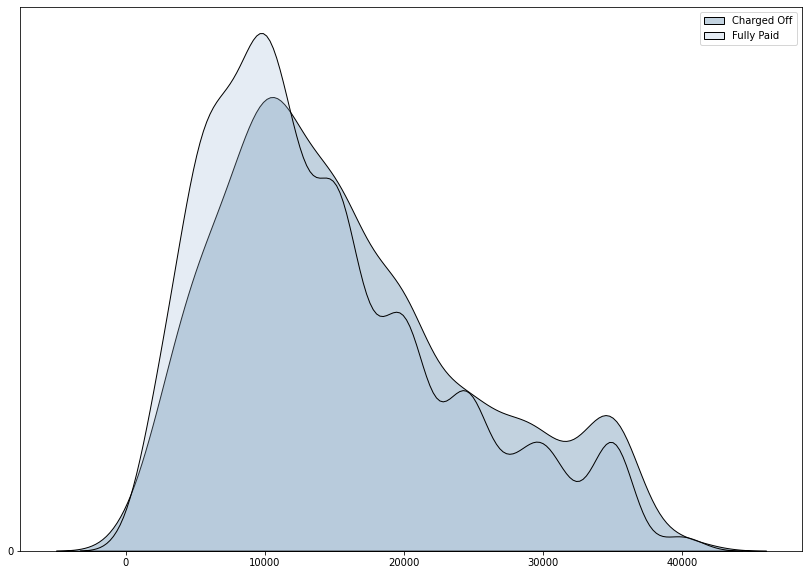

In [550]:
plot_kde('loan_amnt')

Frequency distribution of Loan Amount

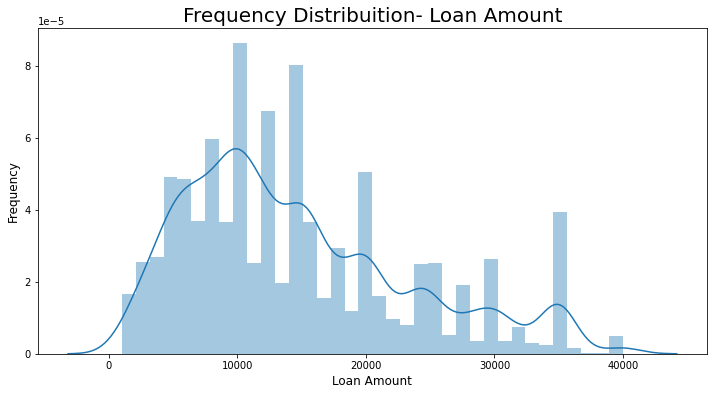

In [551]:
plt.figure(figsize=(12,6))
g = sns.distplot(df["loan_amnt"])
g.set_xlabel("Loan Amount", fontsize=12)
g.set_ylabel("Frequency", fontsize=12)
g.set_title("Frequency Distribuition- Loan Amount", fontsize=20)
plt.show()

Smaller loans tend to be Fully Paid more often

## Loan term

In [552]:
plot_bar(df, 'term')

## Interest rate

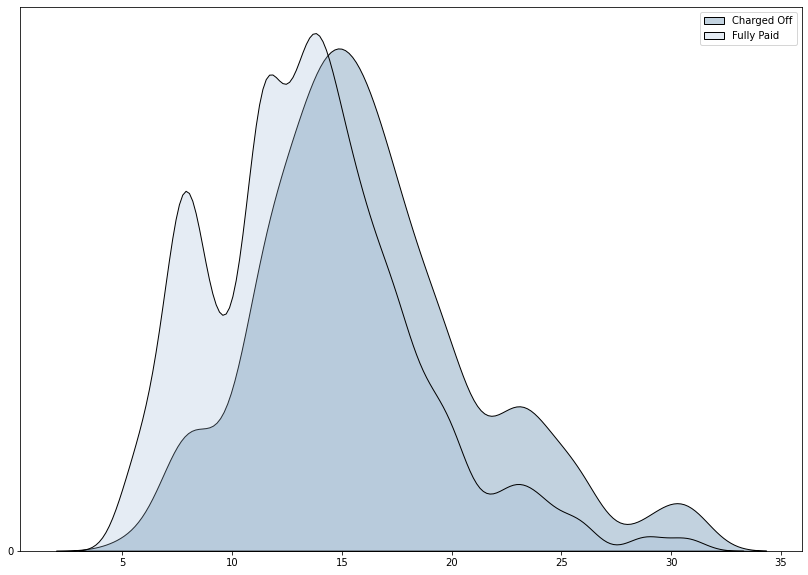

In [553]:
plot_kde('int_rate')

Loans with smaller interest rates tend to be paid more often

Frequency distribution of Interest Rate

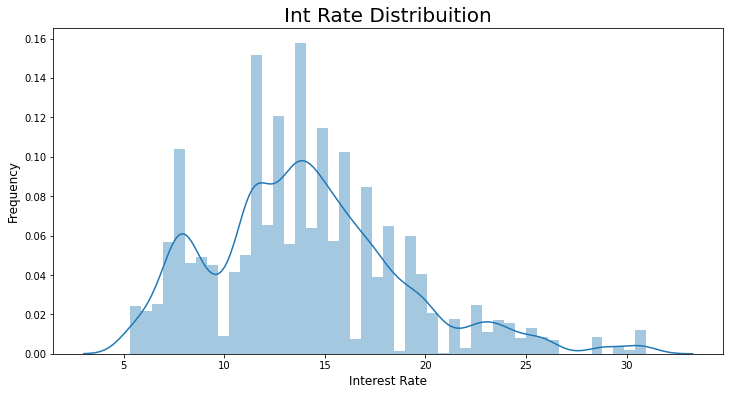

In [554]:
plt.figure(figsize=(12,6))
g = sns.distplot(df["int_rate"])
g.set_xlabel("Interest Rate", fontsize=12)
g.set_ylabel("Frequency", fontsize=12)
g.set_title("Int Rate Distribuition", fontsize=20)
plt.show()

## Loan grades

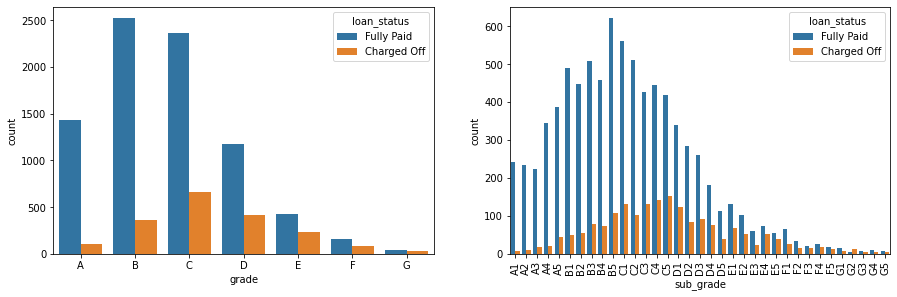

In [556]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
grade = sorted(df.grade.unique().tolist())
sns.countplot(x='grade', data=df, hue='loan_status', order=grade)

plt.subplot(2, 2, 2)
sub_grade = sorted(df.sub_grade.unique().tolist())
g = sns.countplot(x='sub_grade', data=df, hue='loan_status', order=sub_grade)
g.set_xticklabels(g.get_xticklabels(), rotation=90);

The 'larger' the grade of the loan - the bigger the chance of this loan not being paid off. 

## Emplotement lenght

In [557]:
plot_bar(df, 'emp_length')

## Home ownership 

In [558]:
plot_bar(df, 'home_ownership')

## Annual income

In [614]:
bins = (0, 10000, 20000, 30000, 50000, 60000, 70000, 80000, 90000, 100000, 500000, 1000000, 1100000)
labels = ['<10k', '<20k', '<30', '<50k','<60k', '<70k', '<80k', '<90k', '<100k', '<500k', '<1M', '<11M']
df['level_of_inc'] = pd.cut(x = df['annual_inc'], bins = bins, labels = labels)

In [560]:
plot_bar(df, 'level_of_inc')

In [561]:
df = df.drop(columns=['level_of_inc'])

## Crosstabulation of Purpose and Loan Status

In [562]:
purp_loan= ['purpose', 'loan_status']
cm = sns.light_palette("blue", as_cmap=True)
pd.crosstab(df[purp_loan[0]], df[purp_loan[1]]).style.background_gradient(cmap = cm)

loan_status,Charged Off,Fully Paid
purpose,,
car,16,96
credit_card,352,1799
debt_consolidation,1158,4745
home_improvement,115,491
house,8,31
major_purchase,28,145
medical,25,96
moving,10,57
other,117,483


In [563]:
df['purpose'] = df['purpose'].replace({'educational':'other'})
plot_bar(df, 'purpose')

# Feature engeneering
**How fast the customer paid back**

In [564]:
df['last_pymnt_d']= pd.to_datetime(df['last_pymnt_d'])
df['issue_d']= pd.to_datetime(df['issue_d'])

df['time_paid_back'] = ((df['last_pymnt_d'] - df['issue_d'])/np.timedelta64(1, 'M'))
df = df.drop(columns=['last_pymnt_d', 'issue_d'])

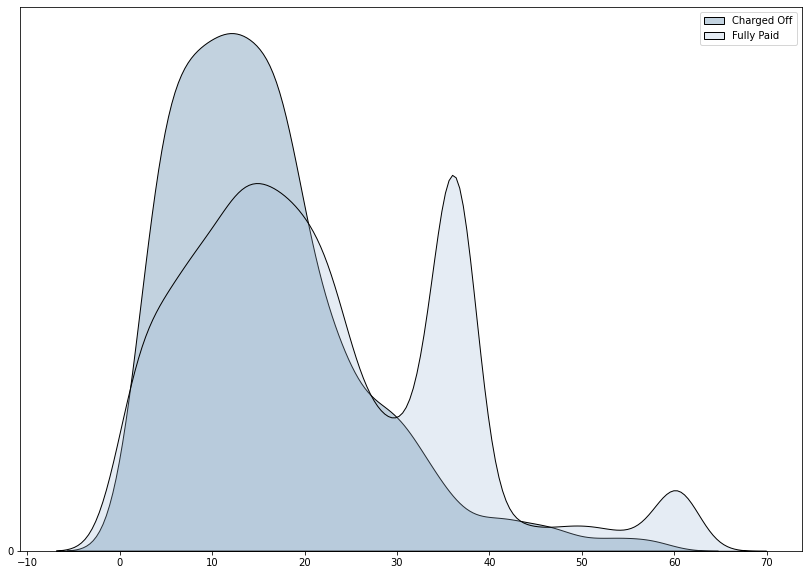

In [565]:
plot_kde('time_paid_back')

We can see a trend here: customers usually fail to pay very early - within the first year. Let me remind you that we have 36 month (3 years) period and 60 months (5 years) period loan term. 

This is visible in this graph too - there is a spike of people concluding their loans right on time - on month 36 and month 60.

**How long customer has a credit account**

In [566]:
df['earliest_cr_line']= pd.to_datetime(df['earliest_cr_line'])
df['cr_line'] = ((pd.to_datetime("now") - df['earliest_cr_line'])/np.timedelta64(1, 'Y'))
df = df.drop(columns=['earliest_cr_line'])

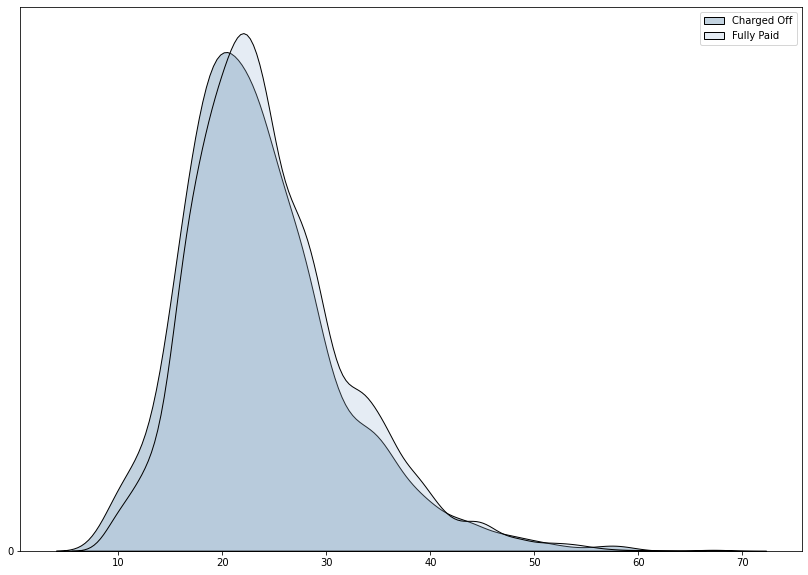

In [567]:
plot_kde('cr_line')

Nothing too interesting here, except that we have customers with credit accounts opened for 50+ years.

# Mapping

In [568]:
grade_mapping = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6}
df.grade = df.grade.map(grade_mapping)

In [569]:
df.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,...,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term,time_paid_back,cr_line
0,5150.0,5150.0,5150.0,60 months,18.64,132.58,4,E1,1 year,RENT,...,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,60.025873,21.691731
1,30000.0,30000.0,30000.0,36 months,8.24,943.42,1,B1,10+ years,OWN,...,Cash,Y,Jan-2019,ACTIVE,Jan-2019,7723.0,50.0,12.0,23.064129,47.189859
2,7200.0,7200.0,7200.0,36 months,28.69,300.51,5,F1,10+ years,MORTGAGE,...,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,11.992033,27.775360
3,7000.0,7000.0,7000.0,36 months,11.49,230.80,1,B5,9 years,MORTGAGE,...,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,17.018830,18.025673
4,11200.0,11200.0,11200.0,36 months,13.99,382.74,2,C3,3 years,RENT,...,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,18.037331,19.104409


In [570]:
sub_grade_mapping = {'A1': 0, 'A2' : 1, 'A3': 2, 'A4': 3, 'A5': 4,
                     'B1': 5, 'B2' : 6, 'B3': 7, 'B4': 8, 'B5': 9,
                     'C1': 10, 'C2' : 11, 'C3': 12, 'C4': 13, 'C5': 14,
                     'D1': 15, 'D2' : 16, 'D3': 17, 'D4': 18, 'D5': 19,
                     'E1': 20, 'E2' : 21, 'E3': 22, 'E4': 23, 'E5': 24,
                     'F1': 25, 'F2' : 26, 'F3': 27, 'F4': 28, 'F5': 29,
                     'G1': 30, 'G2' : 31, 'G3': 32, 'G4': 33, 'G5': 34}
df.sub_grade = df.sub_grade.map(sub_grade_mapping)

In [571]:
employ_mapping = {'< 1 year': 0, 
                  '1 year': 1,
                  '2 years' : 2,
                  '3 years' : 3,
                  '4 years' : 4,
                  '5 years' : 5,
                  '6 years' : 6,
                  '7 years' : 7,
                  '8 years' : 8,
                  '9 years' : 9,
                  '10+ years' : 10}
df.emp_length = df.emp_length.map(employ_mapping)

In [572]:
purpose_mapping = {'debt_consolidation': 0, 
                  'credit_card': 1,
                  'home_improvement': 2,
                  'other': 3,
                  'major_purchase': 4,
                  'car': 5,
                  'vacation': 6,
                  'moving': 7,
                  'house': 8,
                  'renewable_energy': 9,
                  'wedding': 10,
                  'medical': 11,
                  'small_business': 12}

df.purpose = df.purpose.map(lambda x: purpose_mapping.get(x,x))

In [573]:
loan_status_mapping = {'Charged Off': 0, 
                  'Fully Paid': 1}
df.loan_status = df.loan_status.map(loan_status_mapping)


Removing "months" from "36 months" and convert it to int type

In [574]:
df["term"]= df['term'].map(lambda x: x.rstrip('months'))
df["term"]= df["term"].astype("int")

In [575]:
categ = ['term', 'home_ownership', 'initial_list_status', 'application_type', 'verification_status']

le = LabelEncoder()
df[categ] = df[categ].apply(le.fit_transform)

# Hypotesis testing

A few points were not so clear to me.
* Is there really significant difference between 'Individual' loans and 'Joint Application Loans'? 
* Is employement lenght affecting the final outcome of the loan?



H0 => µ1 = µ2 (population mean of dataset1 is equal to dataset2)

HA => µ1 ≠µ2 (population mean of dataset1 is different from dataset2)


In [576]:
stats.ttest_ind(df['emp_length'][df['loan_status'] == 1],
                df['emp_length'][df['loan_status'] == 0])

Ttest_indResult(statistic=nan, pvalue=nan)

In [577]:
stats.ttest_ind(df['application_type'][df['loan_status'] == 1],
                df['application_type'][df['loan_status'] == 0])

Ttest_indResult(statistic=-0.11326851897344659, pvalue=0.9098199489680169)

In [578]:
stats.ttest_ind(df['cr_line'][df['loan_status'] == 1],
                df['cr_line'][df['loan_status'] == 0])

Ttest_indResult(statistic=4.182363074497569, pvalue=2.909571446013254e-05)

All the above-tested features are significant, loan status is influenced by employment length, application type, and how long a person has its credit opened.

## Missing values

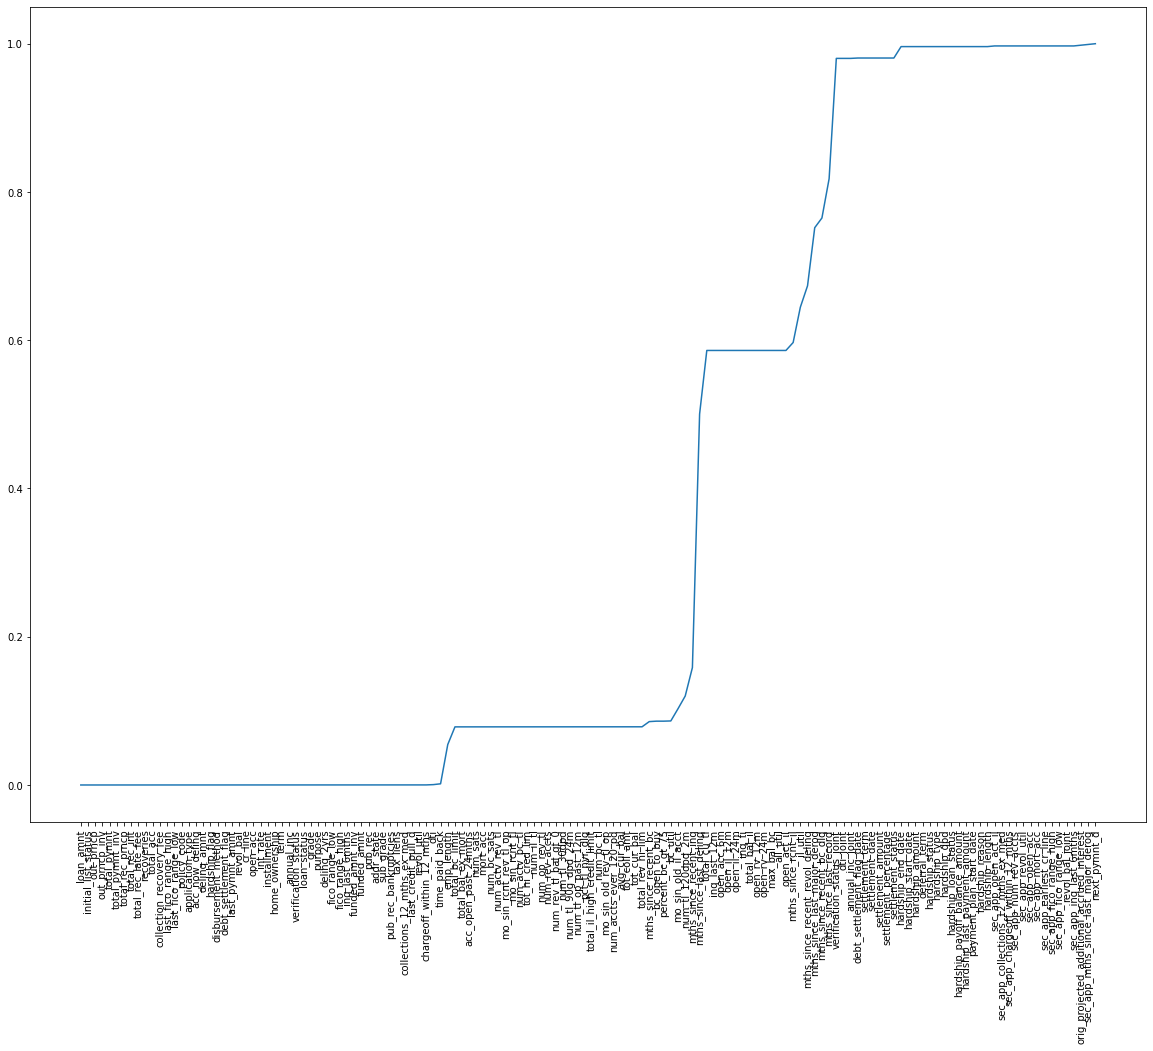

In [579]:
missing_value_train = df.isnull().mean()
plt.subplots(figsize=(20,15))
plt.xticks(rotation=90)
plt.plot(missing_value_train.sort_values())
plt.show()

# Correlations

In [580]:
corr_matrix = df.corr()
print(corr_matrix["loan_status"].sort_values(ascending=False))

loan_status              1.000000
last_fico_range_high     0.652648
last_fico_range_low      0.561078
total_rec_prncp          0.432426
last_pymnt_amnt          0.357267
                           ...   
deferral_term                 NaN
hardship_length               NaN
settlement_amount             NaN
settlement_percentage         NaN
settlement_term               NaN
Name: loan_status, Length: 125, dtype: float64


# Preparing data

In [581]:
target = df['loan_status']
df =  df.drop(columns=["loan_status"])

**One-hot encoding creating new column for each unique category in a categorical variable**

In [582]:
df = pd.get_dummies(df,drop_first=True)
print('Training Features shape: ', df.shape)

Training Features shape:  (10000, 436)


**Filling NAN**

In section 3.4 of their article (https://arxiv.org/pdf/1603.02754v2.pdf), the authors of xgboost explain how they handle missing values when searching for the best candidate split for tree growing. Specifically, they create a default direction for those nodes with, as a splitting feature, one with missing values in the current instance set. 
At prediction time, if the prediction path goes through this node and the feature value is missing, the default direction is followed.

In [583]:
gc.collect()

78691

**Scale**

In [584]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0, 1))
scaler.fit(df)

train_transformed = pd.DataFrame(scaler.transform(df), 
                                 index=df.index, 
                                 columns=df.columns)

**Split to train and set / Stratifying dataset**

In [585]:
from sklearn.model_selection import StratifiedKFold

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

for train_ix, test_ix in kfold.split(train_transformed, target):
    X_training_set, X_validation_set = train_transformed.iloc[train_ix], train_transformed.iloc[test_ix]
    y_training_set, y_validation_set = target.iloc[train_ix], target.iloc[test_ix]

In [586]:
features = list(X_training_set.columns)

# Training the model
## Predicting loan outcome
**OPTUNA hyperparameter tunning**

Optuna objective function is changed to return roc_auc_score, therefore it will optimize to get the best roc auc score possible.

In [587]:
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(lambda trial: classification(trial), n_trials= 10)

[I 2023-03-10 17:48:29,260] A new study created in memory with name: no-name-213c4878-6fa4-4949-9775-3732d9e6c2c4
[I 2023-03-10 17:48:39,652] Trial 0 finished with value: 0.9566183234493962 and parameters: {'booster': 'gbtree', 'lambda': 9.915644566638385e-06, 'alpha': 0.40338008326003827, 'subsample': 0.7855951534491241, 'colsample_bytree': 0.6789267873576292, 'max_depth': 3, 'min_child_weight': 3, 'eta': 2.9152036385288193e-08, 'gamma': 0.08499808989182997, 'grow_policy': 'lossguide'}. Best is trial 0 with value: 0.9566183234493962.
[I 2023-03-10 17:48:44,484] Trial 1 finished with value: 0.9573636962662857 and parameters: {'booster': 'gbtree', 'lambda': 1.4610865886287176e-08, 'alpha': 0.574485163632042, 'subsample': 0.8659541126403374, 'colsample_bytree': 0.36987128854262097, 'max_depth': 3, 'min_child_weight': 3, 'eta': 2.716051144654844e-06, 'gamma': 0.00015777981883364995, 'grow_policy': 'depthwise'}. Best is trial 1 with value: 0.9573636962662857.
[I 2023-03-10 17:48:55,555] Tr

In [588]:
Best_trial = study.best_trial.params
Optuna_XGB_model = XGBClassifier(**Best_trial)
fitted_model = Optuna_XGB_model.fit(X_training_set, y_training_set)
optuna_pred = Optuna_XGB_model.predict(X_validation_set)

In [589]:
fitted_model.save_model('xgb_model_optuna.json')

In [590]:
evaluation(optuna_pred)


 R-Squared :  94.78075926904533

 ROC AUC Score :  0.9798504687530581

 Model Accuracy :  0.992
              precision    recall  f1-score   support

           0       1.00      0.96      0.98       378
           1       0.99      1.00      1.00      1622

    accuracy                           0.99      2000
   macro avg       0.99      0.98      0.99      2000
weighted avg       0.99      0.99      0.99      2000



**Learning more about the model**

In [591]:
explainer = shap.TreeExplainer(fitted_model)
shap_values = explainer.shap_values(X_training_set)

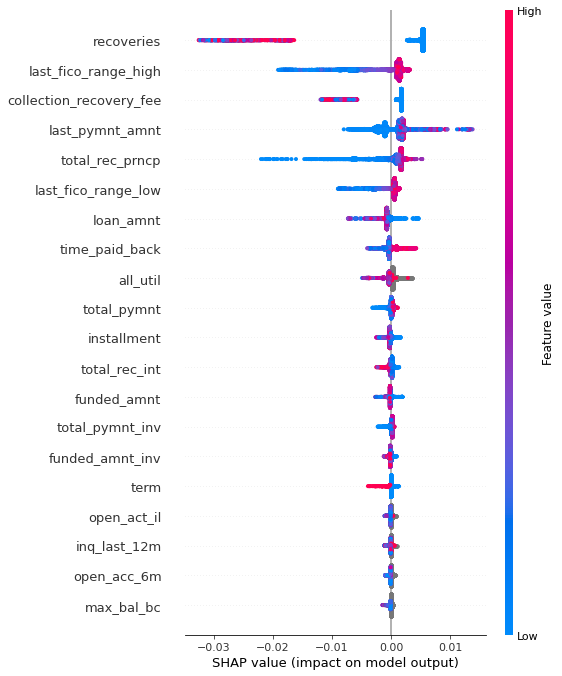

In [592]:
shap.initjs()
shap.summary_plot(shap_values, X_training_set)

As we see a feature called recoveries is the most important for our XGBoost model. Feature 'time paid back' ended up in the top 10 most useful features too. 

## Predicting loan grade

In [593]:
target = df['grade']
df =  df.drop(columns=["grade", "sub_grade"])

In [594]:
gc.collect()

11615

In [595]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0, 1))
scaler.fit(df)

train_transformed = pd.DataFrame(scaler.transform(df), 
                                 index=df.index, 
                                 columns=df.columns)

In [596]:
from sklearn.model_selection import StratifiedKFold

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

for train_ix, test_ix in kfold.split(train_transformed, target):
    X_training_set, X_validation_set = train_transformed.iloc[train_ix], train_transformed.iloc[test_ix]
    y_training_set, y_validation_set = target.iloc[train_ix], target.iloc[test_ix]

In [597]:
features = list(X_training_set.columns)

In [608]:
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(lambda trial: classification_multi(trial), n_trials= 10)

[I 2023-03-10 17:56:32,150] A new study created in memory with name: no-name-4ae66bc5-10cd-4ef5-99f1-911352ca4db9
[I 2023-03-10 17:56:51,687] Trial 0 finished with value: 0.9218341350485048 and parameters: {'booster': 'gblinear', 'lambda': 0.0006155564318973012, 'alpha': 1.77071686435378e-07, 'subsample': 0.32479561626896214, 'colsample_bytree': 0.24646688973455957}. Best is trial 0 with value: 0.9218341350485048.
[I 2023-03-10 17:57:21,090] Trial 1 finished with value: 0.9940516846625703 and parameters: {'booster': 'gbtree', 'lambda': 1.4610865886287176e-08, 'alpha': 0.574485163632042, 'subsample': 0.8659541126403374, 'colsample_bytree': 0.36987128854262097, 'max_depth': 3, 'min_child_weight': 3, 'eta': 2.716051144654844e-06, 'gamma': 0.00015777981883364995, 'grow_policy': 'depthwise'}. Best is trial 1 with value: 0.9940516846625703.
[I 2023-03-10 17:58:22,868] Trial 2 finished with value: 0.9913721631090613 and parameters: {'booster': 'gbtree', 'lambda': 8.528933855762793e-06, 'alpha

In [609]:
Best_trial = study.best_trial.params
Optuna_XGB_model = XGBClassifier(**Best_trial)
fitted_model = Optuna_XGB_model.fit(X_training_set, y_training_set)
optuna_pred = Optuna_XGB_model.predict(X_validation_set)

In [610]:
fitted_model.save_model('xgb_model_grade_optuna.json')

In [611]:
evaluation_multi(optuna_pred)


 R-Squared :  92.75184275184274

 ROC AUC Score :  0.9934229531010992

 Model Accuracy :  0.91
              precision    recall  f1-score   support

           0       0.99      0.90      0.94       307
           1       0.85      0.87      0.86       576
           2       0.88      0.90      0.89       603
           3       0.98      0.99      0.98       318
           4       0.99      0.89      0.94       131
           5       1.00      1.00      1.00        50
           6       1.00      1.00      1.00        15

    accuracy                           0.91      2000
   macro avg       0.95      0.94      0.94      2000
weighted avg       0.91      0.91      0.91      2000



In [612]:
explainer = shap.TreeExplainer(fitted_model)
shap_values = explainer.shap_values(X_training_set)

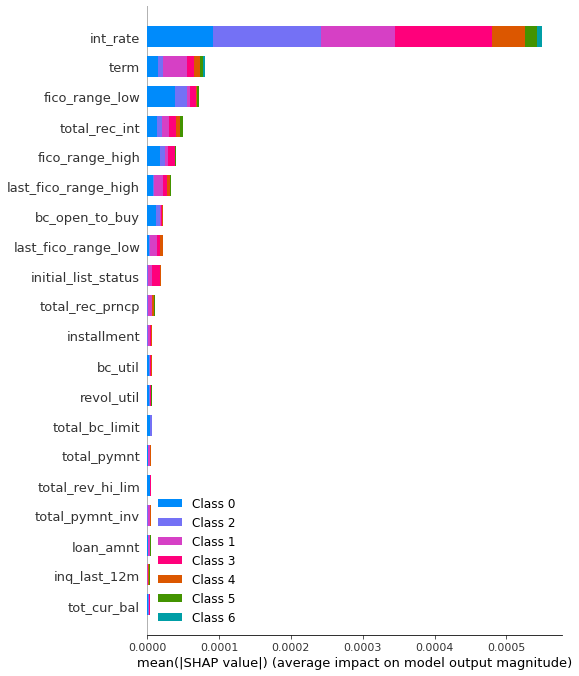

In [613]:
shap.initjs()
shap.summary_plot(shap_values, X_training_set)

The interest rate is highly correlated with the grade of the loan. And that corresponds to our business knowledge: Loans graded A have the lowest expected risk of loss and therefore pay the lender the lowest interest rate. On the other hand, G loans have the highest expected risk of loss. Accordingly, G loans pay the highest interest rate in order to compensate lenders for the increased risk relative to an A loan.

# Conclusion

We successfully build very simple models that can take some details from our customer's bio and credit info, created a few parameters ourselves (how long it is taking to repay, and how long the customer has it's credit account opened), and now can predict loan outcome and loan grade.   

Having an easy-to-interpret model that a loan officer can use to provide immediate estimates can not only speed up the process but also save lenders from potential losses.